# Mathematical Underpinnings - Lab 7

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

c:\users\kmarc\appdata\local\programs\python\python38\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.25.11) or chardet (5.2.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Task 1

### a)

In [2]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    
    Sigma2inv = np.linalg.inv(Sigma2)
    mu_diff = mu2 - mu1
    n = len(mu1)
    
    element1 = mu_diff @ Sigma2inv @ mu_diff
    element2 = np.trace(Sigma2inv @ Sigma1)
    element3 = np.log(np.linalg.det(Sigma1) / np.linalg.det(Sigma2))
    result = (element1 + element2 - element3 - n) / 2
    return result

In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

In [4]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

n = 10000
mu1 = np.array([1, 1, 1, 0, 0]) / 5
mu2 = mu1[::-1]

ones = np.ones((5, 5))
eye = np.eye(5)
Sigma1 = (ones + eye*9) / 10
Sigma2 = (eye*6 - ones) / 5
p = np.random.multivariate_normal(mu1, Sigma1, size=n)
q = np.random.multivariate_normal(mu2, Sigma2, size=n)

x = np.concatenate((p, q))
y = np.concatenate((np.ones(n), np.zeros(n)))

In [5]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [6]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1-y)
    element1 = np.sum(t*y)/n1
    element2 = np.log(np.sum(np.exp(t)*(1-y))/n2)
    return element1 - element2

In [7]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

1.3826768071660394

### c)

In [8]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [9]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [11]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 2s 49ms/step - loss: -0.0248 - val_loss: -0.0450
Epoch 2/100
15/15 [==============================] - 0s 12ms/step - loss: -0.0515 - val_loss: -0.0657
Epoch 3/100
15/15 [==============================] - 0s 10ms/step - loss: -0.0658 - val_loss: -0.0774
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: -0.0743 - val_loss: -0.0844
Epoch 5/100
15/15 [==============================] - 0s 12ms/step - loss: -0.0787 - val_loss: -0.0888
Epoch 6/100
15/15 [==============================] - 0s 13ms/step - loss: -0.0819 - val_loss: -0.0920
Epoch 7/100
15/15 [==============================] - 0s 13ms/step - loss: -0.0843 - val_loss: -0.0946
Epoch 8/100
15/15 [==============================] - 0s 10ms/step - loss: -0.0863 - val_loss: -0.0967
Epoch 9/100
15/15 [==============================] - 0s 11ms/step - loss: -0.0883 - val_loss: -0.0987
Epoch 10/100
15/15 [==============================] - 0s 11ms/step - loss: -0.0900

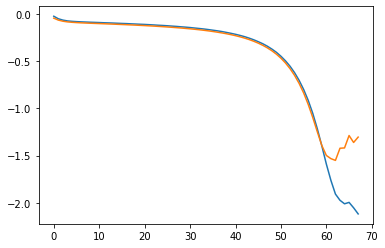

In [12]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [13]:
t_x_pred = model.predict(x)[:,0]

625/625 [==============================] - 2s 3ms/step


In [14]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

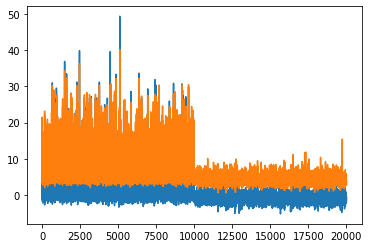

In [15]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

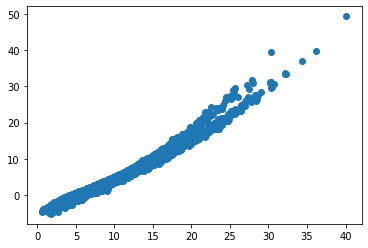

In [16]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [17]:
DV_fun(y, t_x_pred)

0.7682373220442349

In [18]:
DV_fun(y, t_x_opt)

1.3826768071660394

In [19]:
# new data
p = np.random.multivariate_normal(mu1, Sigma1, size=n)
q = np.random.multivariate_normal(mu2, Sigma2, size=n)

x = np.concatenate((p, q))

t_x_pred = model.predict(x)[:,0]
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

625/625 [==============================] - 2s 3ms/step


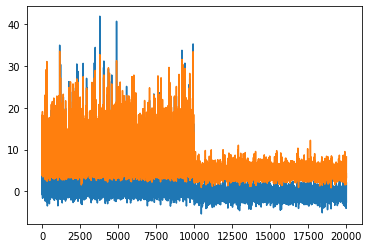

In [20]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

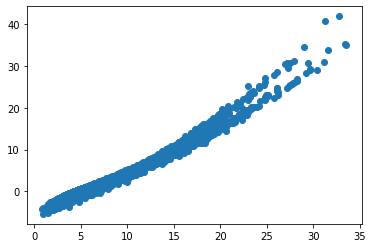

In [21]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [22]:
DV_fun(y, t_x_pred)

1.974467125345102

In [23]:
DV_fun(y, t_x_opt)

2.116350841347252

### f)

In [24]:
def NWJ_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1-y)
    element1 = np.sum(t*y)/n1
    element2 = np.sum(np.exp(t-1)*(1-y))/n2
    return element1 - element2

In [25]:
def NWJ_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.reduce_sum(tf.math.multiply(tf.subtract(tf.math.exp(T_x), tf.convert_to_tensor(1.0)), 
                                                                  tf.subtract(tf.convert_to_tensor(1.0), y_true)
                                                     ))/n2
    return -(first_term - second_term) 

In [26]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
model_outputs = Dense(1)(layer_out)

model2 = keras.Model(model_inputs, model_outputs)
model2.compile(optimizer=optimizer, loss=NWJ_loss)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [28]:
hist = model2.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 1s 25ms/step - loss: 0.2174 - val_loss: 0.0285
Epoch 2/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0109 - val_loss: -0.0027
Epoch 3/100
15/15 [==============================] - 0s 9ms/step - loss: -0.0144 - val_loss: -0.0257
Epoch 4/100
15/15 [==============================] - 0s 12ms/step - loss: -0.0330 - val_loss: -0.0429
Epoch 5/100
15/15 [==============================] - 0s 12ms/step - loss: -0.0465 - val_loss: -0.0556
Epoch 6/100
15/15 [==============================] - 0s 9ms/step - loss: -0.0564 - val_loss: -0.0652
Epoch 7/100
15/15 [==============================] - 0s 8ms/step - loss: -0.0637 - val_loss: -0.0727
Epoch 8/100
15/15 [==============================] - 0s 8ms/step - loss: -0.0696 - val_loss: -0.0785
Epoch 9/100
15/15 [==============================] - 0s 8ms/step - loss: -0.0740 - val_loss: -0.0831
Epoch 10/100
15/15 [==============================] - 0s 9ms/step - loss: -0.0774 - val_lo

Epoch 81/100
15/15 [==============================] - 0s 12ms/step - loss: -0.4907 - val_loss: -0.5228
Epoch 82/100
15/15 [==============================] - 0s 13ms/step - loss: -0.5151 - val_loss: -0.5486
Epoch 83/100
15/15 [==============================] - 0s 12ms/step - loss: -0.5407 - val_loss: -0.5760
Epoch 84/100
15/15 [==============================] - 0s 12ms/step - loss: -0.5689 - val_loss: -0.6052
Epoch 85/100
15/15 [==============================] - 0s 10ms/step - loss: -0.5989 - val_loss: -0.6364
Epoch 86/100
15/15 [==============================] - 0s 12ms/step - loss: -0.6307 - val_loss: -0.6698
Epoch 87/100
15/15 [==============================] - 0s 12ms/step - loss: -0.6640 - val_loss: -0.7052
Epoch 88/100
15/15 [==============================] - 0s 14ms/step - loss: -0.6996 - val_loss: -0.7429
Epoch 89/100
15/15 [==============================] - 0s 12ms/step - loss: -0.7376 - val_loss: -0.7828
Epoch 90/100
15/15 [==============================] - 0s 14ms/step - loss

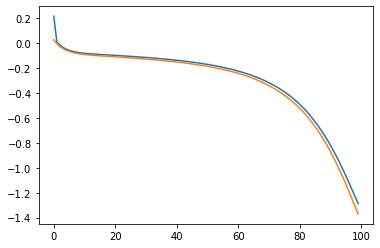

In [29]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [30]:
t_x_pred = model2.predict(x)[:,0]

625/625 [==============================] - 2s 3ms/step


In [31]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

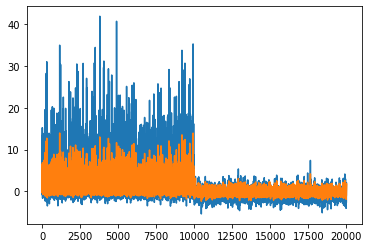

In [32]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

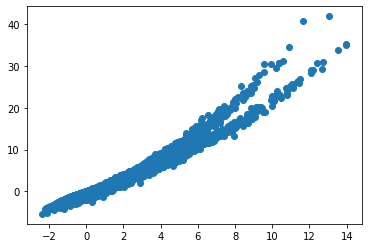

In [33]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [34]:
NWJ_fun(y, t_x_pred)

0.9531473519556224

In [35]:
NWJ_fun(y, t_x_opt)

1.7714920692860814